# Classifying Reddit Posts to Marvel/DC Movie Subreddits Pt 2

## 1. Recap: Problem Statement

We are employees of a marketing agency hired by a toy company to perform market research on Reddit to build a classifier model that classifies posts from Marvel vs DC movies subreddits in order to 
1. Build a classifier model that can be applied to other platforms (e.g. Twitter, Facebook) with text data to determine public interest in either movie franchise
2. Find popular heroes and keywords for each franchise to identify product and marketing opportunities (using sentiment analysis)

The success of the classifier model will be evaluated using the accuracy metric i.e. is the model able to correctly label a post as coming from the Marvel/DC subreddit? Similarly, sentiment analysis will be evaluated using accuracy i.e. is the model able to correctly identify a post as having positive, neutral or negative sentiment? This can help us identify the most discussed heroes and keywords (a sign of popularity) and whether the discussions around these heroes and topics are positive, neutral or negative to identify product and marketing opportunities to boost revenue for our customer, the toy company. 

## 2. Overview of Notebook
This second code notebook will cover the following:
- Data cleaning and EDA
- Data preprocessing using NLP techniques e.g. 
    - Tokenizing
    - Removing stopwords (words that do not convey much meaning)
    - Stemming 
    - Vectorizing
- Model fitting and evaluation
- Sentiment analysis

## 3. Import Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import regex as re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from transformers import pipeline
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
import json
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

import warnings
warnings.filterwarnings("ignore")

/var/folders/8z/79m40r1d0xlgt3j50lw991x40000gn/T/ipykernel_1812/2232588271.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


## 4. Read Data

In this section, we load the data from the Marvel and DC subreddits using the Pushift API in the pt 1 code notebook.

In [2]:
marvel = pd.read_csv('./datasets/marvel.csv')
display(marvel.shape)
marvel.head()

(4997, 85)

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,author_fullname,...,discussion_type,author_flair_background_color,gallery_data,is_gallery,media_metadata,author_cakeday,distinguished,banned_by,call_to_action,category
0,[],False,OutrageousCan366,HulkTR,"[{'e': 'text', 't': 'Hulk'}]",93d81236-e5ea-11e7-a21d-0e4a80901758,Hulk,dark,richtext,t2_bngpojal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,Yeahdude16261,NaN,[],NaN,NaN,NaN,text,t2_k5714qok,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,PhotoConorWilliams,NaN,[],NaN,NaN,NaN,text,t2_29cgz41b,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,Ullaspn_2003,NaN,[],NaN,NaN,NaN,text,t2_75zhhfx6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,inklingboi08,NaN,[],NaN,NaN,NaN,text,t2_3w9e07d1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
dc = pd.read_csv('./datasets/dc.csv')
display(dc.shape)
dc.head()

(4998, 85)

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,...,media_embed,secure_media,secure_media_embed,crosspost_parent,crosspost_parent_list,poll_data,distinguished,banned_by,call_to_action,category
0,[],False,SirSufficient385,NaN,[],NaN,text,t2_d02xl6ar,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,eatherichortrydietin,NaN,[],NaN,text,t2_eop6rrqo,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,scottydoeskno,NaN,[],NaN,text,t2_d4x0p,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,Ecra-8,NaN,[],NaN,text,t2_3sx7ihzq,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,Ecra-8,NaN,[],NaN,text,t2_3sx7ihzq,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 5. Data Cleaning and EDA
In this section we will do the following:
- Examine basic summary statistics
- Examine distributions in important columns
- Identify and address outliers
- Check for and handle missing values in the important columns

### 5.1 Checking the distribution of posts with/without selftext

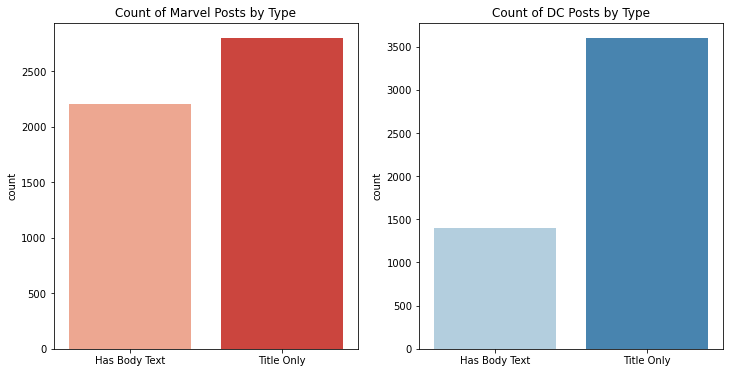

In [4]:
# Check count of posts that have a body text vs posts with title only 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
labels = ['Has Body Text','Title Only']
plot1 = sns.countplot(x=marvel['selftext'].isna(), palette='Reds')
plot1.set_xticklabels(labels)
plt.title('Count of Marvel Posts by Type')
plot1.set_xlabel('')

plt.subplot(1, 2, 2)
plot2 = sns.countplot(x=dc['selftext'].isna(), palette='Blues')
plot2.set_xticklabels(labels)
plt.title('Count of DC Posts by Type')
plot2.set_xlabel('')
plt.show()

### 5.2 Handling missing values: Creating `content` column
There are some missing values in the `selftext` column. This column is the body of text that can be found under the title in a Reddit post but not every Reddit post has a body of text, thus some rows have missing values for the `selftext` column. We can create a new column for model training that concatenates `title` and `selftext` to solve this issue of missing values. 

In [5]:
# Put empty string ' ' for missing values in self-text
marvel.fillna(' ', inplace=True)
dc.fillna(' ', inplace=True)

In [6]:
# Create new column called `content` for marvel and dc dfs
marvel['content'] = marvel['title']+' '+marvel['selftext']
dc['content'] = dc['title']+' '+dc['selftext']

### 5.3 Summary Statistics 
Let's get some summary statistics on the number of characters in the `title` and `selftext` columns from our data.

In [7]:
# Define a function that takes in a dataframe, and list of text columns to return summary stats for 
def text_sum(df, lst=['title', 'selftext']):
    empty_lst = []
    
    for col in lst: 
        dictionary = {} 
        char_cnt = [len(string) for string in df[col]]
        dictionary['mean'] = sum(char_cnt)/len(char_cnt)
        dictionary['std'] = np.std(char_cnt)
        dictionary['median'] = np.percentile(char_cnt, 50)
        dictionary['25th perc'] = np.percentile(char_cnt, 25)
        dictionary['75th perc'] = np.percentile(char_cnt, 75)
        dictionary['min'] = np.percentile(char_cnt, 0)
        dictionary['max'] = np.percentile(char_cnt, 100)
        empty_lst.append(dictionary)
        
    return pd.DataFrame(empty_lst, index=lst).T

In [8]:
# Summary stats for the Marvel subreddit
text_sum(marvel)
# Summary stats for the DC subreddit
text_sum(dc)

,title,selftext
mean,63.863946,122.547419
std,47.950687,597.016959
median,52.000000,1.000000
25th perc,31.000000,1.000000
75th perc,82.000000,9.000000
min,1.000000,1.000000
max,300.000000,16353.000000


Both Marvel and DC have pretty similar summary statistics in terms of the number of characters in the title and body text of each post. The distribution of the number of characters is right-skewed in both subreddits, we see outliers that have much higher character counts than the median. Marvel posts also tend to have longer body text than DC posts. 

### 5.4 Checking the distribution of posts with/without media

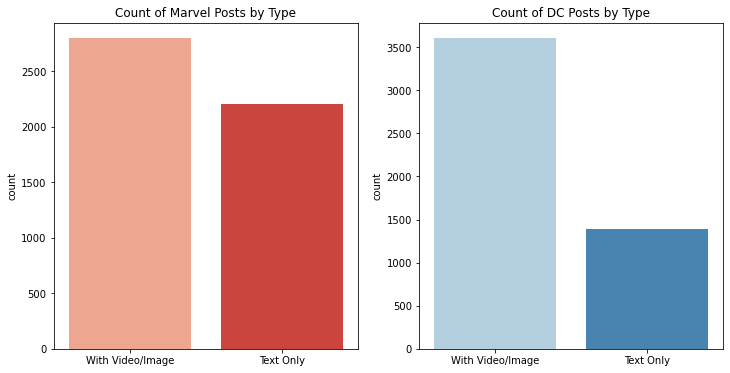

In [9]:
# Check count of posts that have a image/video vs posts with text only
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
labels = ['With Video/Image', 'Text Only']
plot1 = sns.countplot(x=marvel['is_self'], palette='Reds')
plot1.set_xticklabels(labels)
plt.title('Count of Marvel Posts by Type')
plot1.set_xlabel('')

plt.subplot(1, 2, 2)
plot2 = sns.countplot(x=dc['is_self'], palette='Blues')
plot2.set_xticklabels(labels)
plt.title('Count of DC Posts by Type')
plot2.set_xlabel('')
plt.show()

Most posts tend to have some form of media (not just text) which comes as no surprise since these subreddits discuss movies and characters, so images and videos should be expected. 

### 5.5 Top unigrams in each subreddit

In [10]:
# Remove common words that don't convey much meaning 
stopwords_lst = stopwords.words('english')
more_words = ['like', 'just', 'think', 'removed','would','could','should','get'
             ,'also','one','really','movies', 'film', 'new', 'film', 'https', 'movie'
             ,'show', 'see']
stopwords_lst.extend(more_words)

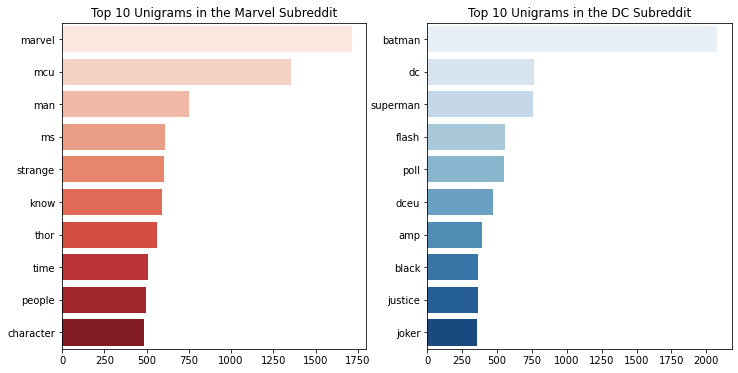

In [11]:
# Instantiate CountVectorizer
cvec = CountVectorizer(stop_words=stopwords_lst)

# Vectorise and put vectors into dataframe for Marvel
marvel_words = cvec.fit_transform(marvel['content']) 
marvel_words_df = pd.DataFrame(marvel_words.toarray(), columns=cvec.get_feature_names_out())

# Vectorise and put vectors into dataframe for DC
dc_words = cvec.fit_transform(dc['content']) 
dc_words_df = pd.DataFrame(dc_words.toarray(), columns=cvec.get_feature_names_out())

# Find top 10 words in both subreddits
marv_cnt = pd.DataFrame(marvel_words_df.sum().sort_values(ascending=False).head(10), columns=['count'])
dc_cnt = pd.DataFrame(dc_words_df.sum().sort_values(ascending=False).head(10), columns=['count'])

# Bar plot of top 10 words 
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.barplot(x=marv_cnt['count'], y=marv_cnt.index.tolist(), palette='Reds').set(xlabel=None)
plt.title('Top 10 Unigrams in the Marvel Subreddit')

plt.subplot(1,2,2)
sns.barplot(x=dc_cnt['count'], y=dc_cnt.index.tolist(), palette='Blues').set(xlabel=None)
plt.title('Top 10 Unigrams in the DC Subreddit')

plt.show()

### 5.6 Top bigrams in each subreddit

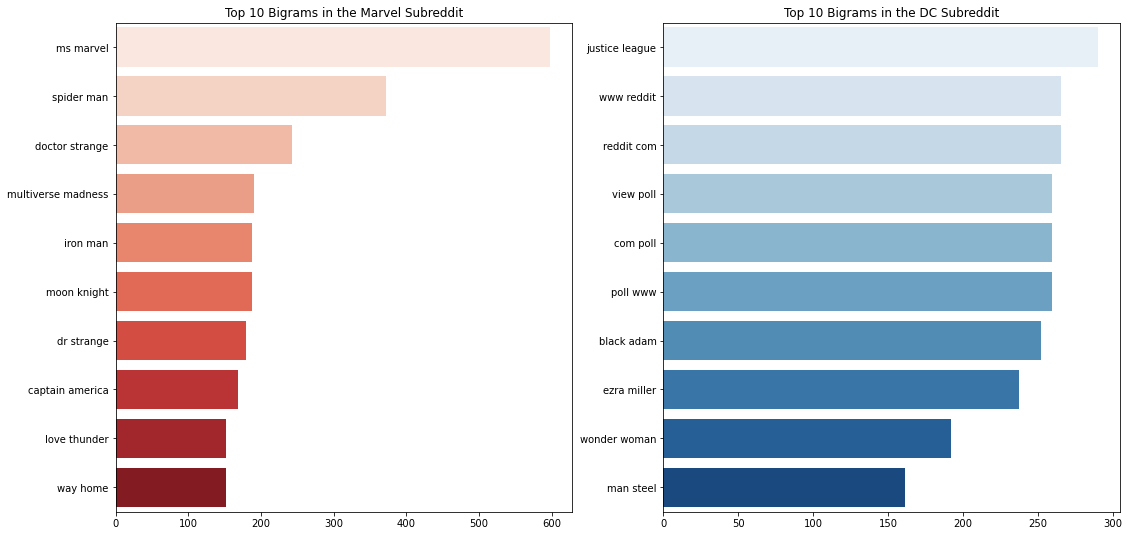

In [12]:
# Instantiate CountVectorizer
cvec = CountVectorizer(stop_words=stopwords_lst, ngram_range=(2,2))

# Vectorise and put vectors into dataframe for Marvel
marvel_words = cvec.fit_transform(marvel['content']) 
marvel_words_df = pd.DataFrame(marvel_words.toarray(), columns=cvec.get_feature_names_out())

# Vectorise and put vectors into dataframe for DC
dc_words = cvec.fit_transform(dc['content']) 
dc_words_df = pd.DataFrame(dc_words.toarray(), columns=cvec.get_feature_names_out())

# Find top 10 bigrams in both subreddits
marv_cnt = pd.DataFrame(marvel_words_df.sum().sort_values(ascending=False).head(10), columns=['count'])
dc_cnt = pd.DataFrame(dc_words_df.sum().sort_values(ascending=False).head(10), columns=['count'])

# Bar plot of top 10 words 
plt.figure(figsize=(18,9))

plt.subplot(1,2,1)
sns.barplot(x=marv_cnt['count'], y=marv_cnt.index.tolist(), palette='Reds').set(xlabel=None)
plt.title('Top 10 Bigrams in the Marvel Subreddit')

plt.subplot(1,2,2)
sns.barplot(x=dc_cnt['count'], y=dc_cnt.index.tolist(), palette='Blues').set(xlabel=None)
plt.title('Top 10 Bigrams in the DC Subreddit')

plt.show()

### 5.7 Overall findings

This section has given us a pretty good start to answer our objectives. The top unigrams and bigrams give an indication of the potential strongest features that can help us build a classfier model that produces accurate predictions. Once we build our model and analyse feature importance, we can look back to this section to do a sanity check on the features we got from the model. 

The top unigrams and bigrams also help us identify the most popular and most disscussed keywords and heroes to identify product and marketing opportunities. We will use sentiment analysis in a later section to determine if the discussions around these words are positive, neutral or negative. 

## 6. Data Preprocessing

- Lowercase
- Tokenization
- Stop Word Removal
- Special Char Removal
- Stemming/Lemmatization

In [13]:
# Combine marvel and dc dfs
df = pd.concat([marvel[['subreddit', 'content']], dc[['subreddit', 'content']]]).reset_index(drop=True)
display(df.shape)

(9995, 2)

In [14]:
# Define a function that takes in a series and 
# Returns a series that is a cleaned up version of the input series

def word_cleaner(str_lst):
    # Instantiate stemmer/lemmatizer
    p_stemmer = PorterStemmer()
    # lemmatizer = WordNetLemmatizer()
    
    # 1. Make all strings lowercase 
    lst_clean_1 = [string.lower().strip() for string in str_lst]
    
    # 2. Regex to remove any non-latin characters 
    lst_clean_2 = [re.sub("[^a-zA-Z]", " ", string) for string in lst_clean_1]
    
    # 3. Tokenize 
    lst_tokenized = [word_tokenize(string) for string in lst_clean_2]
    
    # 4. Remove stop words
    lst_stopped = [[word for word in lst if word not in stopwords_lst] for lst in lst_tokenized]
    
    # 5. Stem words 
    lst_stem = [[p_stemmer.stem(word) for word in lst] for lst in lst_stopped]
    
    # # 5. Alternatively, lemmatize words 
    # lst_lem = [[lemmatizer.lemmatize(word) for word in lst] for lst in lst_tokenized]

    # 6. Put list of words back into 1 string per row
    lst_cleaned = [' '.join(lst) for lst in lst_stem]
    # lst_cleaned = [' '.join(lst) for lst in lst_lem]
    
    return lst_cleaned

In [15]:
# Create a new column that is the cleaned up version of the `content` column 
df['content_clean'] = word_cleaner(df['content'])

In [16]:
# Create new colum `class` where 1=marvel, 0=DC
df['class']=df['subreddit'].map({'marvelstudios':1, 'DC_Cinematic':0})

In [17]:
# Check that the dataframe looks as expected 
df.head()

,subreddit,content,content_clean,class
0,marvelstudios,Thor: Love and Thunder,thor love thunder,1
1,marvelstudios,why is Bucky Barnes so popular? [removed],bucki barn popular,1
2,marvelstudios,How would you feel about an Avengers style app...,feel aveng style approach set x men mcu start ...,1
3,marvelstudios,Is this omnipotent city,omnipot citi,1
4,marvelstudios,This is the explanation I'll be using from now...,explan use,1


## 7. Baseline Model

The baseline model provides a benchmark to measure model performance against. 

If we were given a random post and had to classify it under the Marvel or DC subreddit, our best guess (without using machine learning models) would be to use the proportion of each class in the dataset i.e. if the target class comprises 90% of the dataset, our best guess would be predict that any random post belongs to the target class. 

We can then improve upon this baseline score using machine learning models and a variety of techniques e.g. feature engineering, hyperparameter tuning, dimensionality reduction etc. to make predictions better. 

In [18]:
df['subreddit'].value_counts(normalize=True)

DC_Cinematic     0.50005
marvelstudios    0.49995
Name: subreddit, dtype: float64

## 8. Model Testing and Fitting and Evaluation

In [19]:
# Create X and y
X = df['content_clean']
y = df['class']

### 8.1 Random Forest, SVM, Naive Bayes and Logistic Regression Models

Let's try these different classifier models with different vectorizers to find the combination which produces the best accuracy score.

In [20]:
# Instantiate transformers 
cvec = CountVectorizer()
tvec = TfidfVectorizer()

# Instantiate models 
rf = RandomForestClassifier()
svc = SVC()
nb = MultinomialNB()
logreg = LogisticRegression()

In [21]:
# Create list of dictionary of parameters to GridSearch over for transformers and models 
params = {
    'cvec':{ # default parameters performed the best!
        # 'ngram_range':[(1,1), (2,2)],
        # 'max_df':[0.95, 1.0],
        # 'min_df':[1, 2]
        # 'max_features':[]
    },
    'tvec':{
        # 'ngram_range':[(1,1), (2,2)],
        # 'max_df':[0.95, 1.0],
        # 'min_df':[1, 2], 
        'max_features': [6_000, 7_000]
    # 'max_features':[]
    },
    'rf':{
        'n_estimators': [100, 150, 200], # iterating over different number of trees in the forest
        # 'max_depth': [None, 1, 2, 3, 4, 5]
    },
    'svc':{
        'C':[1.0, 0.1, 0.01],
        'kernel':['linear', 'poly', 'rbf'], 
        'degree':[2]
    },
    'nb':{
        'alpha':[1.0, 10.0]
    },
    'logreg':{
        'penalty':['l1', 'l2'],
        'C':[1.0, 0.1, 0.01],
        'solver':['liblinear']
    }  
}

In [22]:
# Def function that takes in list of dict keys and full dict of parameters and returns a dict of parameters specified in list 
def params_fx(lst, dictionary=params):
    dict_param = {}
    for item in lst:
        for key,value in dictionary[item].items(): 
            dict_param[item+"__"+key]=value
    return dict_param

In [23]:
# Def function that takes in X, y, transformers, a model and a dictionary of hyperparameters for the model 
# Returns cross val score, test score, train score 
def all_model_scores(X, y, vectorizer, estimator, param_lst): 
    # Pipeline
    pipe = Pipeline([
    (param_lst[0], vectorizer), 
    (param_lst[1], estimator)])
    
    # Instantiate GridSearchCV 
    pipe_gs = GridSearchCV(pipe,
                           params_fx(param_lst), # use params function to call dict of params 
                           cv=5,
                           verbose=1)
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
    
    # Fit pipe on training data
    pipe_gs.fit(X_train, y_train)
    
    # Cross validation 
    cv_scores = cross_val_score(pipe_gs, X_train, y_train, cv=5)
    
    all_scores = {
        'cross val mean score':cv_scores.mean(), 
        'cross val std':cv_scores.std(), 
        'train score':pipe_gs.score(X_train, y_train),
        'test score':pipe_gs.score(X_test, y_test)
    }
    
    # Return pipeline gridsearch and scores 
    return [pipe_gs, all_scores]

In [24]:
# CountVectorizer and Random Forest model 
cvec_rf_score = all_model_scores(X, y, cvec, rf, ['cvec', 'rf'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [25]:
# CountVectorizer and Naive Bayes model 
cvec_nb_score = all_model_scores(X, y, cvec, nb, ['cvec', 'nb'])

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [26]:
# TfidfVectorizer and SVM model 
tvec_svm_score = all_model_scores(X, y, tvec, svc, ['tvec', 'svc'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [27]:
# TfidfVectorizer and Logistic Regression
tvec_logreg_score = all_model_scores(X, y, tvec, logreg, ['tvec', 'logreg'])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


### 8.2 Zero Shot Classification Model (Pretrained Model)

Let's try the **bart-large-mnli model** which is a pretrained, zero shot classification model from Hugging Face. This model takes in a string/sequence of strings to be classified and labels to classify each string of text as. For example, you could give the model the text 'I want to eat apples' and two labels - 'fruit' or 'vegetable' and the model returns probabilities for each label for the given text e.g. {'fruit' : 80%, 'vegetable' : 20%}. 

Note: The zero shot model code is commented out because it takes a long time to run and the output has already been saved to a csv file. 

In [32]:
# # Problem: After content is cleaned, some rows contain '' (but not NA) which cannot be used by zero shot 
# # Fix: If content_clean='', replace it with the original post 
# df['content_clean'] = [cont.strip() if clean_cont=='' else clean_cont for cont, clean_cont in zip(df['content'], df['content_clean'])]
# # df.head()

In [33]:
# # Zero shot model 
# classifier = pipeline("zero-shot-classification",
#                       model="facebook/bart-large-mnli")

# # Labels to classify each post as 
# labels = ['marvel', 'dc']

# # Create a new column in df to store the entire output of the model 
# df['zero_shot_output'] = df['content_clean'].progress_apply(classifier, candidate_labels=labels)

In [34]:
# # Write zero shot output to csv (just in case!)
# # df.to_csv('./datasets/df_zero_shot.csv')
# df = pd.read_csv('./datasets/df_zero_shot.csv')

In [35]:
# # Create a new df column that contains the zero shot predicted class 
# df['zero_shot_predict']=[1 if dictionary['scores'][0]>dictionary['scores'][1] else 0 for dictionary in df['zero_shot_output']]

In [36]:
# # Calculate zero shot accuracy
# correct_pred_cnt = sum(df['class']==df['zero_shot_predict'])
# correct_pred_cnt/df['class'].count()

Unfortunately, the accuracy score (0.49!) from this zero shot model is no better than our baseline model. Let's do some investigation to find out why by looking at the model predictions that do not match the actual data.

In [37]:
# # Take a look at the predictions that are wrong
# df[df['class']!=df['zero_shot_predict']].head()

For some reason, it seems that posts from the DC subreddit tend to be misclassfiied as Marvel (even when classic DC characters are mentioned in the post). It seems that the model is unable to recognize attribute DC characters to the DC label. This could be because the label 'DC' only has two alphabets and may not be meaningful/recognizable enough. Safe to say, we won't be using this model as our final production model!

In [38]:
# # Pipeline
# pipe = Pipeline([
# ('cvec', cvec), 
# ('nb', nb)])

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# # Fit pipe on training data
# pipe.fit(X_train, y_train)

# # Predictions 
# y_pred = pipe.predict(X_test)

# # Get the index of test data rows to get the raw (before preprocessing) content
# X_test_raw = df['content'][X_test.index.tolist()]

# # Create a dataframe for easy comparison
# predict_comparison = pd.DataFrame(data={'X_test_raw': X_test_raw,
#                                         'X_test':X_test,
#                                         'y_test':y_test, 
#                                         'y_pred':y_pred})

# # Find rows where model predictions don't match actual data 
# mismatched = predict_comparison[predict_comparison['y_test']!=predict_comparison['y_pred']]
# mismatched.to_csv('./datasets/nb_model_mismatches.csv')

### 8.3 Choosing and Evaluating the Production Model

In [39]:
pd.DataFrame([cvec_rf_score[1], cvec_nb_score[1], tvec_svm_score[1], tvec_logreg_score[1]], 
             index=['cvec_rf', 'cvec_nb', 'tvec_svm', 'tvec_logreg'])

,cross val mean score,cross val std,train score,test score
cvec_rf,0.896212,0.006818,0.995064,0.893157
cvec_nb,0.901815,0.007441,0.937300,0.911965
tvec_svm,0.910087,0.005845,0.987860,0.911965
tvec_logreg,0.906485,0.008478,0.958378,0.904362


### 8.4 Final Model: Logistic Regression
- Based on test scores, the random forest model is eliminated because it has the lowest score
- The remaining SVM, Naive Bayes and Logistic Regression models have similar test scores
- The SVM model has the highest overfitting (train score higher than test score) so it is eliminated  
- The Naive Bayes model has 2 significant disadvantages, especially in the context of our business problem:
    - Naive Bayes assumes independence between words which definitely does not apply here 
        - E.g. A post that talks about the 'batman' movie is likely to mention other relevant keywords/characters like 'robin', 'joker', 'dark knight' etc.
    - Feature importance is calculated using the predicted probabilities however these probabilities from the Naive Bayes model are known to be quite unreliable which might affect the accuracy of our final list of features because we need to know the most important features for our business problem, it's not just the accuracy of predictions that matter. 
- Thus, Logistic Regression is chosen as our final production model! 

### 8.4 Interpreting the Final Model 

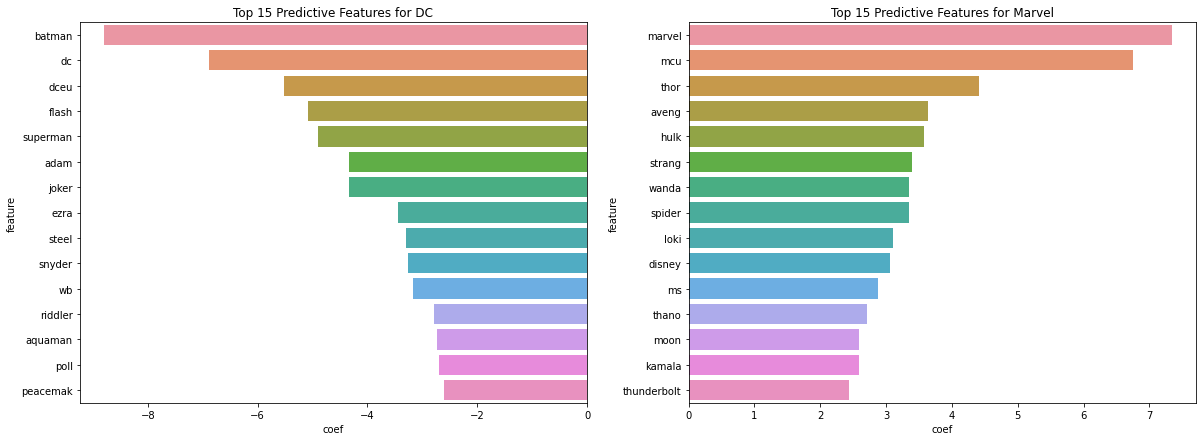

In [40]:
# Put the coefficients from pipeline into df 
coefs = pd.DataFrame(tvec_logreg_score[0].best_estimator_.steps[1][1].coef_).T
coefs.columns = ['coef']
coefs['feature'] = tvec_logreg_score[0].best_estimator_.steps[0][1].get_feature_names()
coefs = coefs[['feature','coef']]
coefs = coefs.sort_values('coef', ascending=True)

# Get top DC and top marvel features and coefficients
top_dc_coefs = coefs.head(15).reset_index(drop=True)
top_marvel_coefs = coefs.tail(15).sort_values(by='coef', ascending=False).reset_index(drop=True)

fig, axs = plt.subplots(1, 2, figsize=(20,7))
axs[0].title.set_text('Top 15 Predictive Features for DC')
axs[1].title.set_text('Top 15 Predictive Features for Marvel')
sns.barplot(data = top_dc_coefs, x = 'coef',y='feature',ax = axs[0])
sns.barplot(data = top_marvel_coefs, x = 'coef',y='feature',ax = axs[1])
plt.show()

## 9. Sentiment Analysis

### 9.1 Choosing a sentiment analysis model

Let's try the **cardiffnlp/twitter-roberta-base-sentiment** and **finiteautomata/bertweet-base-sentiment-analysis** model which are models trained on huge datasets of tweets from Hugging Face. These models were chosen because they produce positive, neutral and negative labels (some models only produce positive/negative labels). They take in a string/sequence of strings to be classified and classify each string of text as 'POS'/'NEU'/'NEG' along with a score to indicate how positive/neutral/negative the string is. 

We'll test these 2 models on a human labelled dataset of 300 rows to see which gives us better accuracy and subsequently run the better performing model on our entire datset.

In [41]:
# Let's load 2 sentiment analysis models to compare their accuracy on a human labelled test dataset
sent_classifier0 = pipeline("sentiment-analysis", 
                            model="cardiffnlp/twitter-roberta-base-sentiment",  
                            max_length=512, 
                            truncation=True)

sent_classifier = pipeline("sentiment-analysis", 
                          model="finiteautomata/bertweet-base-sentiment-analysis", 
                          truncation=True)

In [42]:
# Load the human labelled dataset 
sentiment_test = pd.read_csv('./datasets/manual_sentiment_annotated_data - manual_sentiment_annotated_data.csv')

In [43]:
# Run both sentiment analysis models on the posts 
sentiment_test['model_output0'] = sentiment_test['post_demojized_only'].progress_apply(sent_classifier0)
sentiment_test['model_output'] = sentiment_test['post_demojized_only'].progress_apply(sent_classifier)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [44]:
# Put both models' predictions into a new column
sentiment_test['model0_label']=[lst[0]['label'] for lst in sentiment_test['model_output0']]
sentiment_test['model0_label']=sentiment_test['model0_label'].map({'LABEL_0':'NEG', 'LABEL_1':'NEU', 'LABEL_2':'POS'})
sentiment_test['model_label']=[lst[0]['label'] for lst in sentiment_test['model_output']]

In [45]:
# Calculate each model's accuracy
correct_pred_cnt0 = sum(sentiment_test['manual_sentiment']==sentiment_test['model0_label'])
print(f"model0 accuracy: {correct_pred_cnt0/sentiment_test['manual_sentiment'].count()}")

correct_pred_cnt = sum(sentiment_test['manual_sentiment']==sentiment_test['model_label'])
print(f"model accuracy: {correct_pred_cnt/sentiment_test['manual_sentiment'].count()}")

model0 accuracy: 0.7566666666666667
model accuracy: 0.7333333333333333


The **cardiffnlp** model gave us slightly better accuracy so let's proceed with that for the entire dataset.

### 9.2 Running sentiment analysis on our dataset

In [47]:
# # Create a new column in df to store the entire output of sentiment analysis
# df['sentiment_output'] = df['content'].progress_apply(sent_classifier0)

In [48]:
# # Create a new df column that contains the labels and scores from sentiment analysis
# df['sentiment_label']=[lst[0]['label'] for lst in df['sentiment_output']]
# df['sentiment_label']=df['sentiment_label'].map({'LABEL_0':'NEG', 'LABEL_1':'NEU', 'LABEL_2':'POS'})
# df['sentiment_score']=[lst[0]['score'] for lst in df['sentiment_output']]

In [49]:
# Write sentiment analysis output to csv (just in case!)
# df.to_csv('./datasets/df_sentiment.csv', index=False)

In [50]:
df = pd.read_csv('./datasets/df_sentiment.csv')

In [51]:
# Drop extra index columns
df.drop(labels=['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)

In [52]:
df.groupby(['sentiment_label', 'class']).count()

subreddit  content  content_clean  zero_shot_output  \
sentiment_label class                                                        
NEG             0            697      697            697               697   
                1            690      690            690               690   
NEU             0           3373     3373           3373              3373   
                1           3328     3328           3328              3328   
POS             0            928      928            928               928   
                1            979      979            979               979   

                       zero_shot_predict  sentiment_output  sentiment_score  
sentiment_label class                                                        
NEG             0                    697               697              697  
                1                    690               690              690  
NEU             0                   3373              3373             3373  
                1                   3328              3328             3328  
POS             0                    928               928              928  
                1                    979               979              979

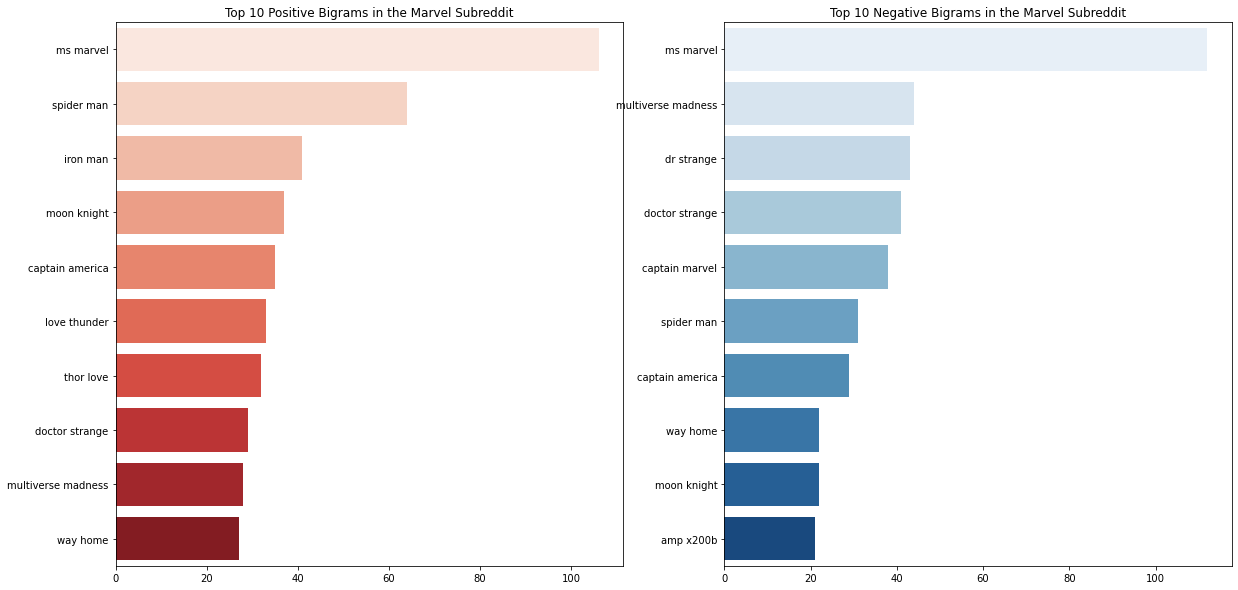

In [53]:
# Instantiate CountVectorizer
cvec = CountVectorizer(stop_words=stopwords_lst, ngram_range=(2,2))

# Filter for positive content from marvel and dc
marv_pos = df['content'][(df['class']==1) & (df['sentiment_label']=='POS')]

# Filter for negative content from marvel and dc
marv_neg = df['content'][(df['class']==1) & (df['sentiment_label']=='NEG')]

# Vectorise and put vectors into dataframe for Marvel
marvel_pos_words = cvec.fit_transform(marv_pos) 
marvel_pos_words_df = pd.DataFrame(marvel_pos_words.toarray(), columns=cvec.get_feature_names_out())
marvel_neg_words = cvec.fit_transform(marv_neg) 
marvel_neg_words_df = pd.DataFrame(marvel_neg_words.toarray(), columns=cvec.get_feature_names_out())

# Find top 10 words in both subreddits
marv_pos_cnt = pd.DataFrame(marvel_pos_words_df.sum().sort_values(ascending=False).head(10), columns=['count'])
marv_neg_cnt = pd.DataFrame(marvel_neg_words_df.sum().sort_values(ascending=False).head(10), columns=['count'])
# dc_cnt = pd.DataFrame(dc_pos_words_df.sum().sort_values(ascending=False).head(10), columns=['count'])

# Bar plot of top 10 words 
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.barplot(x=marv_pos_cnt['count'], y=marv_pos_cnt.index.tolist(), palette='Reds').set(xlabel=None)
plt.title('Top 10 Positive Bigrams in the Marvel Subreddit')

plt.subplot(1,2,2)
sns.barplot(x=marv_neg_cnt['count'], y=marv_neg_cnt.index.tolist(), palette='Blues').set(xlabel=None)
plt.title('Top 10 Negative Bigrams in the Marvel Subreddit')

plt.show()

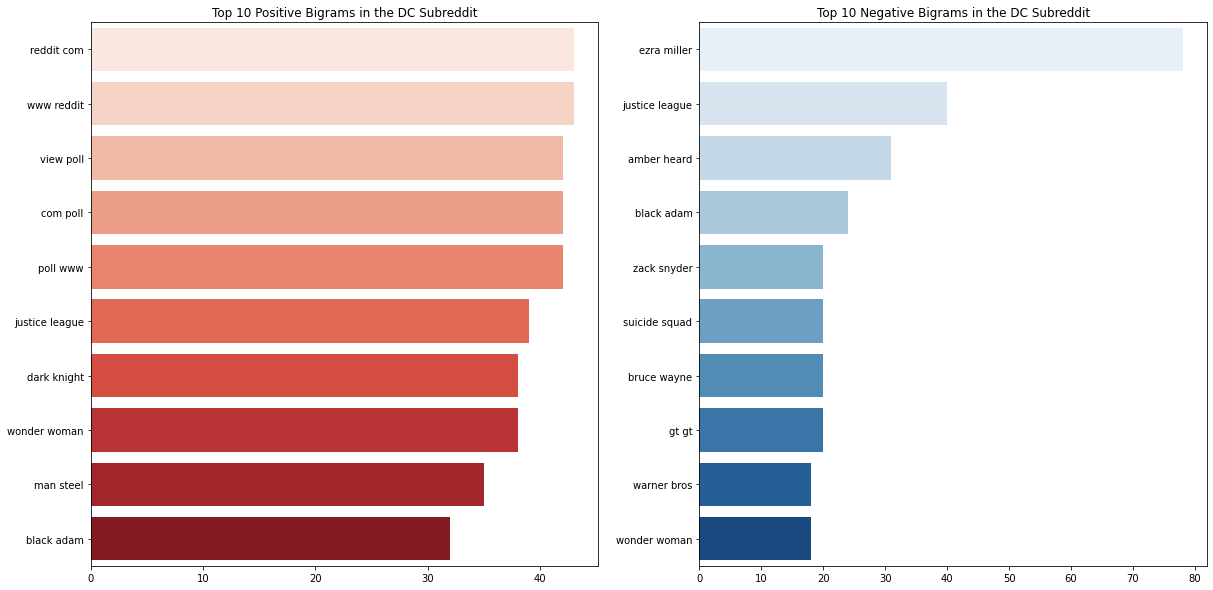

In [54]:
# Instantiate CountVectorizer
cvec = CountVectorizer(stop_words=stopwords_lst, ngram_range=(2,2))

# Filter for positive content from marvel and dc
dc_pos = df['content'][(df['class']==0) & (df['sentiment_label']=='POS')]

# Filter for negative content from marvel and dc
dc_neg = df['content'][(df['class']==0) & (df['sentiment_label']=='NEG')]

# Vectorise and put vectors into dataframe for Marvel
dc_pos_words = cvec.fit_transform(dc_pos) 
dc_pos_words_df = pd.DataFrame(dc_pos_words.toarray(), columns=cvec.get_feature_names_out())
dc_neg_words = cvec.fit_transform(dc_neg) 
dc_neg_words_df = pd.DataFrame(dc_neg_words.toarray(), columns=cvec.get_feature_names_out())

# # Find top 10 words in both subreddits
dc_pos_cnt = pd.DataFrame(dc_pos_words_df.sum().sort_values(ascending=False).head(10), columns=['count'])
dc_neg_cnt = pd.DataFrame(dc_neg_words_df.sum().sort_values(ascending=False).head(10), columns=['count'])
# dc_cnt = pd.DataFrame(dc_pos_words_df.sum().sort_values(ascending=False).head(10), columns=['count'])

# Bar plot of top 10 words 
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.barplot(x=dc_pos_cnt['count'], y=dc_pos_cnt.index.tolist(), palette='Reds').set(xlabel=None)
plt.title('Top 10 Positive Bigrams in the DC Subreddit')

plt.subplot(1,2,2)
sns.barplot(x=dc_neg_cnt['count'], y=dc_neg_cnt.index.tolist(), palette='Blues').set(xlabel=None)
plt.title('Top 10 Negative Bigrams in the DC Subreddit')

plt.show()

## 10. Conclusion

In conclusion, we've managed to build a model that is able to classify Reddit posts as Marvel/DC content with pretty good accuracy! 

1. This model can be used to classify data from other non-Reddit sources as Marvel/DC and possible applications include: 
- Determining popularity/public interest in each brand on other platforms with text data such as Twitter or Facebook in order to do market sizing analysis and estimate revenue potential on potential customers by platform or demographic
- Other downstream analysis e.g. sentiment analysis 

2. Key findings from sentiment analysis include: 
- Popular characters to develop toys and marketing initivatives for, e.g. 
    - Marvel: Ms Marvel, Spiderman, Iron Man, Captain America
    - DC: Batman, Joker
- Key actors/characters to avoid due to negative sentiment 
    - Although the most popular characters tend to appear under top words with positive AND negative sentiment, some phrases/actors/characters under the negative sentiment lists should be avoided altogether due to legal issues/controversy
